In [ ]:
import sys
print(sys.executable)

modules established
Baseline
MODEL OUTPUTS TO BE PRINTED TO THIS DOC
Processing year 2022

Shape of input data
feature shape: (426, 256, 256, 22)
target shape: (426, 65536)
22
['fSCA', 'DMFSCA', 'DOY', 'Tree Density', 'LandCover', 'ASOML_CON_waterbodies_1_0_60_albn83', 'ASOML_CON_windScour_60_albn83_scl', 'ASO_CON_aspect_albn83_60m_scl', 'ASO_CON_curv_albn83_60m_scl', 'ASO_CON_DaH_albn83_60m_scl', 'ASO_CON_dem_albn83_60m_scl', 'ASO_CON_GausCurv_albn83_60m_scl', 'ASO_CON_gradMag_60_albn83_scl', 'ASO_CON_lat_albn83_60m_scl', 'ASO_CON_lon_albn83_60m_scl', 'ASO_CON_PlanCurv_albn83_60m_scl', 'ASO_CON_ProCurv_albn83_60m_scl', 'ASO_CON_slope_albn83_60m_scl', 'ASO_CON_stdElv_60_albn83_scl', 'ASO_CON_STDslope_albn83_60m_scl', 'ASO_CON_TPI_albn83_60m_scl', 'ASO_CON_TRASP_albn83_60m_scl']
***
________________________________ Training and Validation Data Shapes ________________________________
Training data shape: (362, 256, 256, 22) (362, 65536)
Validation data shape: (64, 256, 256, 22) (64, 6553

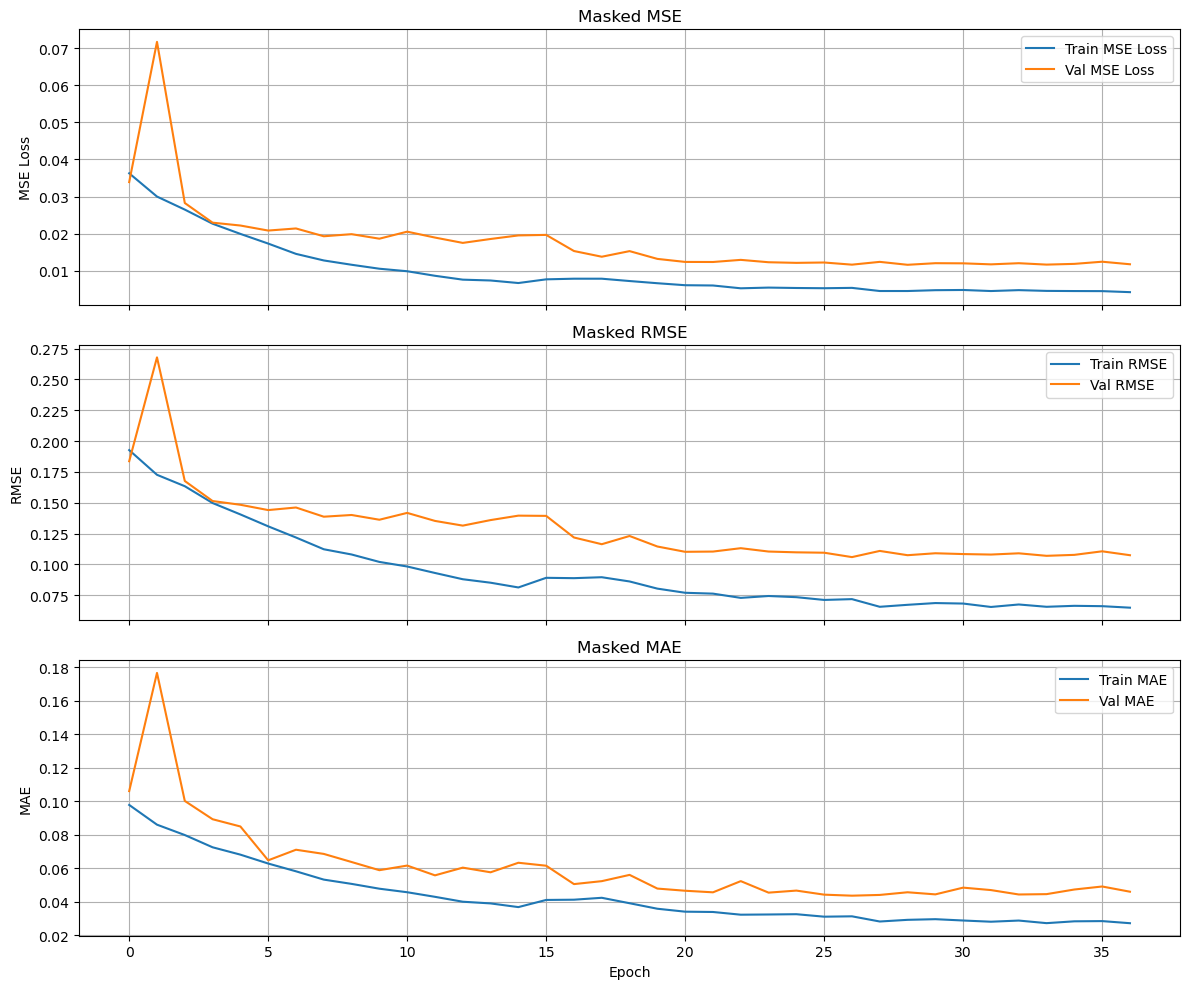


Validation Metric Progression:
val_masked_rmse: Start = 0.1836, End = 0.1075
val_masked_rmse: Best = 0.1060
val_masked_mse: Start = 0.0339, End = 0.0117
val_masked_mse: Best = 0.0116
val_masked_mae: Start = 0.1061, End = 0.0461
val_masked_mae: Best = 0.0437
Final activation function: relu
Current memory usage: 9443.5 MB

 ############### MOVING TO TEST GROUPS OF DATA ###############

Testing Group1
made output directory
X_train shape: (76, 256, 256, 22)
y_train shape: (76, 65536)
X_test shape: (31, 256, 256, 22)
y_test shape: (31, 65536)
Attempting to load weights from: D:/ASOML/Rockies/modelOutputs/20250714_104757//best_weights_20250714_104757.h5
Successfully loaded weights from: D:/ASOML/Rockies/modelOutputs/20250714_104757//best_weights_20250714_104757.h5
Frozen 16 layers
Trainable 2 layers
Epoch 1/5
4/4 [==============================] - 4s 739ms/step - loss: 0.0230 - masked_rmse: 0.1499 - masked_mae: 0.0789 - masked_mse: 0.0230 - val_loss: 0.0382 - val_masked_rmse: 0.1955 - val_m

In [8]:
# pseduo code
import sys
sys.path.append("D:/ASOML/SNOCONE")
from CNN_memoryOptimization import clear_memory, memory_efficient_prediction, DataGenerator
from CNN_preProcessing import min_max_scale, read_aligned_raster, save_array_as_raster, target_feature_stacks, target_feature_stacks_testGroups
from CNN_benchmarks import swe_fsca_consistency_loss_fn, make_swe_fsca_loss, masked_loss_fn, masked_mse, masked_mae, masked_rmse
from CNN_modelArchitectureBlocks import conv_block, identity_block, basic_block, resnet_model_implementation, model_predict, load_and_prepare_model, Baseline_CNN
import rasterio
import shap
import pandas as pd
from rasterio.mask import mask
from rasterio.windows import from_bounds
import psutil
from rasterio.transform import from_bounds 
import numpy as np
import sys
import os
import subprocess
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.utils import register_keras_serializable
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from keras.layers import Dense, Dropout, Flatten, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Dense, BatchNormalization, Activation, Input, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time
import matplotlib.pyplot as plt
from rasterio.transform import from_bounds
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.losses import Loss
import gc
import tensorflow.keras.backend as K

start_time = time.time()
print("modules established")

## establish file paths
# years = list(range(2022, 2023))
start_year = 2022
end_year = 2022
Domain = "Rockies"
GPU = "N"
output_txt = "N"

# workspaces
WorkspaceBase = f"D:/ASOML/{Domain}/"
phv_features = WorkspaceBase + "features/scaled/"
tree_workspace = WorkspaceBase + "treeCover/"
land_workspace = WorkspaceBase + "landCover/"
modelOuptuts = WorkspaceBase + "modelOutputs/"
DMFSCAWorkspace = WorkspaceBase + "Rockies_DMFSCA/"
final_activation = 'relu'
architectures = ['Baseline']  # Options are: Baseline, ResNet18, ResNet34, ResNet50, CustomSWE

test_groups = [
            ('Group1', 2025, 'G1'),
            ('Group2', 2025, 'G2'), 
            ('Group3', 2025, 'G3'),
            ('Group4', 2025, 'G4'),
            ('Group5', 2025, 'G5'),
            ('Group6', 2025, 'G6')
        ]

_mae_metric = MeanAbsoluteError()
_mse_metric = MeanSquaredError()
_rmse_metric = MeanSquaredError()

# # Check GPU availability
if GPU == "Y":
    print("\n Checking and start running on GPU")
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    print("GPU devices:", tf.config.list_physical_devices('GPU'))
    
    # Configure GPU memory growth (prevents TensorFlow from allocating all GPU memory)
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("GPU memory growth enabled")
        except RuntimeError as e:
            print(e)
    
    # Verify TensorFlow is using GPU
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
        c = tf.matmul(a, b)
        print("GPU computation result:", c)

for architecture in architectures:
    print(architecture)
    # shapeChecks = "N"
    ## seting folder
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    # create folder for model outputs
    os.makedirs(modelOuptuts + f"{str(timestamp)}/", exist_ok=True)
    inter_model_outWorkspace = modelOuptuts + f"{str(timestamp)}/"

    if output_txt == 'Y':
        f = open(inter_model_outWorkspace + f"code_output_{timestamp}.txt", "a")
        sys.stdout = f
        
    print("MODEL OUTPUTS TO BE PRINTED TO THIS DOC")
    X, y, featureNames = target_feature_stacks(start_year=start_year, 
                                               end_year=end_year, 
                                               WorkspaceBase=WorkspaceBase, 
                                               ext = "nonull_fnl.tif", 
                                               vegetation_path = tree_workspace, 
                                               landCover_path = land_workspace, 
                                               phv_path = phv_features , 
                                               target_shape=(256,256),
                                               shapeChecks="Y")
    
    print("")
    print("Shape of input data")
    print(f"feature shape: {X.shape}")
    print(f"target shape: {y.shape}")
    feat_shape = X.shape
    featNo = feat_shape[-1]
    print(featNo)
    print(featureNames)
    
    # split between training and test data
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, shuffle=True)
    print("***")
    print("________________________________ Training and Validation Data Shapes ________________________________")
    print("Training data shape:", X_train.shape, y_train.shape)
    print("Validation data shape:", X_valid.shape, y_valid.shape)
    print("***")
    x_trainShape = X_train.shape
    x_validShape = X_valid.shape

    # Assuming featNo and final_activation are defined in your original code
    featNo = featNo  # Replace with your actual feature count
    final_activation = final_activation  # Replace with your actual activation
    
    # Create the model
    model = resnet_model_implementation(featNo, architecture, final_activation)
    
    # Your existing custom loss function
    from tensorflow.keras.losses import MeanSquaredError
    from tensorflow.keras.metrics import MeanAbsoluteError
    
    custom_loss_fn = make_swe_fsca_loss(
        base_loss_fn=MeanSquaredError(),
        penalty_weight=0.3,
        swe_threshold=0.01,
        fsca_threshold=0.01,
        mask_value=-1
    )
    
    # Compile with your existing setup
    model.compile(
        optimizer='adam',
        loss=custom_loss_fn,
        metrics=[masked_rmse, masked_mae, masked_mse]
    )
    
    print(model.summary())
    
    # establish the model
    best_weights_path = f"{inter_model_outWorkspace}/best_weights_{timestamp}.h5"
    checkpoint = ModelCheckpoint(best_weights_path, 
        monitor="val_loss",
        verbose=1, 
        save_best_only=True, 
        mode='min'
    )
    early_stopping = EarlyStopping(monitor="val_masked_rmse", mode='min', verbose=1, patience=10, restore_best_weights=True)
    
    
    batch_size = 32
    train_generator = DataGenerator(X_train, y_train, batch_size=batch_size)
    valid_generator = DataGenerator(X_valid, y_valid, batch_size=batch_size)
    
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=100,
        callbacks=[checkpoint, early_stopping]
    )

    # manual backup save of weights
    backup_weights_path = f"{inter_model_outWorkspace}/backup_weights_{timestamp}.h5"
    try:
        model.save_weights(backup_weights_path)
        print(f"Backup weights saved to: {backup_weights_path}")
    except Exception as e:
        print(f"Failed to save backup weights: {e}")
    
    # Also save model architecture as JSON for SHAP compatibility
    model_json = model.to_json()
    with open(f"{inter_model_outWorkspace}/model_architecture_{timestamp}.json", "w") as json_file:
        json_file.write(model_json)
    print("Model architecture saved as JSON")

    ## plotting results 
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    # 1. Masked MSE (used as loss)
    axs[0].plot(history.history['loss'], label='Train MSE Loss')
    axs[0].plot(history.history['val_loss'], label='Val MSE Loss')
    axs[0].set_ylabel('MSE Loss')
    axs[0].set_title('Masked MSE')
    axs[0].legend()
    axs[0].grid(True)
    # 2. Masked RMSE
    axs[1].plot(history.history['masked_rmse'], label='Train RMSE')
    axs[1].plot(history.history['val_masked_rmse'], label='Val RMSE')
    axs[1].set_ylabel('RMSE')
    axs[1].set_title('Masked RMSE')
    axs[1].legend()
    axs[1].grid(True)
    # 3. Masked MAE
    axs[2].plot(history.history['masked_mae'], label='Train MAE')
    axs[2].plot(history.history['val_masked_mae'], label='Val MAE')
    axs[2].set_ylabel('MAE')
    axs[2].set_title('Masked MAE')
    axs[2].set_xlabel('Epoch')
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.savefig(inter_model_outWorkspace + "Model_error_epochs.png")
    plt.show()
    
    ## Add metrics to recurring error tracking sheet
    metrics_to_track = ['val_masked_rmse', 'val_masked_mse', 'val_masked_mae']
    best_metrics = {}
    print("\nValidation Metric Progression:")
    for metric in metrics_to_track:
        values = history.history.get(metric, [])
        if values:
            best_val = min(values)
            best_metrics[metric] = best_val
            print(f"{metric}: Start = {values[0]:.4f}, End = {values[-1]:.4f}")
            print(f"{metric}: Best = {best_val:.4f}")
        else:
            print(f"{metric}: Not found in history.")
    print(f"Final activation function: {final_activation}")
    
    # Example variables
    feature_csv = modelOuptuts + f"{Domain}_model_featureList_summary.csv" 
    column_name = timestamp  
    feature_list = featureNames    
    new_column_df = pd.DataFrame({column_name: feature_list})
    
    # If the file already exists, load it and append the new column
    if os.path.exists(feature_csv):
        existing_df = pd.read_csv(feature_csv)
        # Reindex the existing dataframe 
        max_len = max(len(existing_df), len(new_column_df))
        existing_df = existing_df.reindex(range(max_len))
        new_column_df = new_column_df.reindex(range(max_len))
        # Combine horizontally
        combined_df = pd.concat([existing_df, new_column_df], axis=1)
    else:
        combined_df = new_column_df
    
    # Save back to CSV
    combined_df.to_csv(feature_csv, index=False)
    
    # add metrics to csv
    modelStatsCSV = modelOuptuts + f"{Domain}_modelSummary_stats.csv"
    
    baseline_stats = {
        'ModelRun':[timestamp],
        'FeatureNum': [featNo],
        'Architecture': [architecture],
        'FinalActivation': [final_activation],
        'X_TrainShape': [x_trainShape[0]],
        'X_ValidShape': [x_validShape[0]],
        'RMSE': [best_metrics['val_masked_rmse']],
        'MSE': [best_metrics['val_masked_mse']], 
        'MAE': [best_metrics['val_masked_mae']]
        
    }
    
    df = pd.DataFrame(baseline_stats)
    
    # Append or write new file
    if os.path.exists(modelStatsCSV):
        df.to_csv(modelStatsCSV, mode='a', header=False, index=False)
    else:
        df.to_csv(modelStatsCSV, index=False)
    
    del X_train, X_valid, y_train, y_valid, X, y
    K.clear_session()
    gc.collect()

    del history 
    clear_memory()

    # create folder
    print("\n ############### MOVING TO TEST GROUPS OF DATA ###############")
    for group_name, year, group_id in test_groups:
        print(f"\nTesting {group_name}")
        
        # Create output folder
        out_folder = inter_model_outWorkspace + f"outTifs_{group_id}_yPreds_tifs/"
        os.makedirs(out_folder, exist_ok=True)
        print("made output directory")
        
        # Load test data
        X_train_g, y_train_g, g_train_extents, g_train_crs = target_feature_stacks_testGroups(
            year=year,
            target_splits_path=WorkspaceBase + f"test_groups/{group_name}/train/",
            fSCA_path=WorkspaceBase + f"{year}/fSCA/",
            DMFSCA_path=WorkspaceBase + f"{year}/DMFSCA/",
            vegetation_path=WorkspaceBase + "treeCover/",
            landCover_path=land_workspace,
            phv_path=WorkspaceBase + "features/scaled/",
            extension_filter=".tif",
            desired_shape=(256, 256),
            debug_output_folder="./debug_outputs/",
            num_of_channels=featNo,
            shapeChecks="Y"
        )
        
        X_test_g, y_test_g, g_test_extents, g_test_crs = target_feature_stacks_testGroups(
            year=year,
            target_splits_path=WorkspaceBase + f"test_groups/{group_name}/test/",
            fSCA_path=WorkspaceBase + f"{year}/fSCA/",
            DMFSCA_path=WorkspaceBase + f"{year}/DMFSCA/",
            vegetation_path=WorkspaceBase + "treeCover/",
            landCover_path=land_workspace,
            phv_path=WorkspaceBase + "features/scaled/",
            extension_filter=".tif",
            desired_shape=(256, 256),
            debug_output_folder="./debug_outputs/",
            num_of_channels=featNo,
            shapeChecks="Y"
        )
        
        # Convert to arrays
        X_train_array = np.array(X_train_g)
        y_train_array = np.array(y_train_g)
        X_test_array = np.array(X_test_g)
        y_test_array = np.array(y_test_g)
        print(f"X_train shape: {X_train_array.shape}")
        print(f"y_train shape: {y_train_array.shape}")
        print(f"X_test shape: {X_test_array.shape}")
        print(f"y_test shape: {y_test_array.shape}")

        # reload loss functions
        custom_loss_fn = make_swe_fsca_loss(
        base_loss_fn=MeanSquaredError(),
        penalty_weight=0.3,
        swe_threshold=0.01,
        fsca_threshold=0.01,
        mask_value=-1
        )
        # add in test model with the weights and test different weights options
        operational_model = resnet_model_implementation(featNo, architecture, final_activation)

        # Try multiple weight file locations
        weight_files = [
            f"{inter_model_outWorkspace}/best_weights_{timestamp}.h5",
            f"{inter_model_outWorkspace}/backup_weights_{timestamp}.h5",
            f"{inter_model_outWorkspace}/best_weights_{timestamp}.weights.h5"
        ]
        
        weights_loaded = False
        for weight_file in weight_files:
            if os.path.exists(weight_file):
                try:
                    print(f"Attempting to load weights from: {weight_file}")
                    operational_model.load_weights(weight_file)
                    print(f"Successfully loaded weights from: {weight_file}")
                    weights_loaded = True
                    break
                except Exception as e:
                    print(f"Failed to load weights from {weight_file}: {e}")

        if not weights_loaded:
            print("ERROR: Could not load any weights file. Check if training completed successfully.")
            print("Available files in directory:")
            for file in os.listdir(inter_model_outWorkspace):
                if 'weights' in file or file.endswith('.h5'):
                    print(f"  - {file}")
            continue  # Skip this test group

        # only adapting the very final layers
        for layer in operational_model.layers[:-2]:  # Freeze ALL but last 2 layers
            layer.trainable = False

        print(f"Frozen {len([l for l in operational_model.layers if not l.trainable])} layers")
        print(f"Trainable {len([l for l in operational_model.layers if l.trainable])} layers")
    
        # compile model
        operational_model.compile(
            optimizer=Adam(learning_rate=1e-6),
            loss=custom_loss_fn,
            metrics=[masked_rmse, masked_mae, masked_mse]
        )

        # add in early stops
        adaptation_early_stop = EarlyStopping(
            monitor='val_loss', 
            patience=3,  # Very short patience
            restore_best_weights=True,
            verbose=1
        )

        #fine tune model
        adaptation_history = operational_model.fit(
            X_train_array, y_train_array,
            batch_size=16,
            epochs=5,  # Very few epochs
            validation_split=0.15,
            callbacks=[adaptation_early_stop],
            verbose=1
        )
        # Make predictions
        print("Making predictions on test data...")
        predictions = operational_model.predict(X_test_array, batch_size=32, verbose=1)

        # Evaluate the model on test data
        print("Evaluating model on test data...")
        test_metrics = operational_model.evaluate(X_test_array, y_test_array, batch_size=32, verbose=1)

        # Print test metrics
        print(f"\n{group_name} Operational Results (Adapted to 2025):")
        print(f"Masked MSE (Loss): {test_metrics[0]:.4f}")
        print(f"Masked RMSE:       {test_metrics[1]:.4f}")
        print(f"Masked MAE:        {test_metrics[2]:.4f}")
        print(f"Masked MSE Metric: {test_metrics[3]:.4f}")

        print("\n--- Baseline Comparison (No Adaptation) ---")
        baseline_model = resnet_model_implementation(featNo, architecture, final_activation)
        baseline_model.load_weights(best_weights_path)
        baseline_model.compile(
            optimizer='adam',
            loss=custom_loss_fn,
            metrics=[masked_rmse, masked_mae, masked_mse]
        )
        
        # Process predictions and save
        for i, pred in enumerate(predictions): # CHECK TO SEE IF THIS IS THE CORRECT SYNTAX
            array = pred.reshape((256, 256))
            mask = y_test_g[i].reshape((256, 256)) != -1
            array_masked = np.where(mask, array, -1)
            
            save_array_as_raster(
                output_path=f"{out_folder}/prediction_{i}.tif",
                array=array_masked.astype(np.float32),
                extent=g_test_extents[i],
                crs=g_test_crs[i],
                nodata_val=-1
            )
            
            del array, mask, array_masked
        
        # Save adaptation metrics
        adaptation_metrics = {
            'Group': [group_name],
            'Baseline_RMSE': [baseline_stats['RMSE'][0]],
            'Adapted_RMSE': [test_metrics[1]],
            'Adapted_MSE': [test_metrics[3]],
            'Adapted_MAE': [test_metrics[2]],
            'Improvement': [baseline_stats['RMSE'][0] - test_metrics[1]],
            'Adaptation_Epochs': [len(adaptation_history.history['loss'])],
            'Final_Val_Loss': [min(adaptation_history.history.get('val_loss', [float('inf')]))]
        }
        
        adaptation_df = pd.DataFrame(adaptation_metrics)
        modelWS = modelOuptuts + f"{str(timestamp)}/"
        adaptation_csv = modelWS + f"operational_adaptation_results.csv"
        
        if os.path.exists(adaptation_csv):
            adaptation_df.to_csv(adaptation_csv, mode='a', header=False, index=False)
        else:
            adaptation_df.to_csv(adaptation_csv, index=False)
            
        # Cleanup
        del operational_model, baseline_model, custom_loss_fn
        del X_train_g, y_train_g, g_train_extents, g_train_crs
        del X_test_g, y_test_g, g_test_extents, g_test_crs
        del X_train_array, y_train_array, X_test_array, y_test_array
        del predictions, test_metrics
        del adaptation_history
        
        clear_memory()
        print(f"{group_name} operational testing completed\n")
        
        # End timing for this architecture
        end_time = time.time()
        total_minutes = (end_time - start_time) / 60
        print(f"\nArchitecture {architecture} completed in {total_minutes:.2f} minutes")

    try:
        f.close()
        sys.stdout = sys.__stdout__ 
    except:
        pass
    clear_memory()